<a href="https://colab.research.google.com/github/lizhieffe/language_model/blob/main/Shakespeare_LM_v1_FFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
USE_GPU = True

BLOCK_SIZE = 50 # Context length: how many chars do we take to predict the next one?

# Setup GPU

In [4]:
if USE_GPU:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  assert device != 'cpu', "GPU is not available"
else:
  device = 'cpu'

print(device)

cuda:0


In [5]:
g_cpu = torch.Generator(device='cpu').manual_seed(2147483647) # for reproducibility
g_device = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

# Util Functions

In [6]:
def _total_params(layers):
  """ Get the total parameter number.

  Args:
    layers: the list of layers of the model

  Returns:
    Number of total parameters
  """
  total_params = 0
  for l in layers:
    for p in l.parameters():
      total_params += p.data.nelement()
  return total_params

In [7]:
def _sample_one_batch(X, Y, batch_size, generator):
  """Sample from ds and generate a batch.

  Args:
    X: features of ds
    Y: labels of ds
    batch_size: batch size
    generator: a pseudorandom number generator for sampling
  Returns:
    Xb: batched features
    Yb: batched labels
  """
  ix = torch.randint(0, X.shape[0], (batch_size, ), generator=generator).to(device)
  # print(f'{ix.device=}')
  Xb, Yb = X[ix], Y[ix]
  return Xb, Yb

In [8]:
def _calculate_loss(Xb, Yb, layers):
  """ Calculate loss.

  Args:
    Xb: the feature batch
    Yb: the label batch
    layers: the layers of the model

  Returns:
    loss: the calculated loss
  """
  emb = C[Xb]
  # print(f'{emb.device=}')
  x = emb.view(emb.shape[0], -1)
  # print(f'{x.device=}')
  for l in layers:
    x = l(x)
    # print(f'{x.device=}')
  loss = F.cross_entropy(x, Yb)
  # print(f'{loss.device=}')
  return loss

# Load data

In [9]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read in all the words
text = open('input.txt', 'r').read()

text[:800]

--2023-10-01 19:26:16--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.5’

input.txt.5         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-10-01 19:26:16 (18.7 MB/s) - ‘input.txt.5’ saved [1115394/1115394]



"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to p"

In [10]:
print(f'total char # = {len(text)}')

total char # = 1115394


# Build vocabulary

In [11]:
chars = sorted(list(set(''.join(text))))

stoi = {c:i+1 for i,c in enumerate(chars)}
stoi['[MASK]'] = 0
itos = {i:c for c,i in stoi.items()}

assert len(stoi) == len(itos)

vocab_size = len(stoi)

EXPECTED_VOCAB_SIZE = 66
assert vocab_size == EXPECTED_VOCAB_SIZE, f"expected vocab size = {EXPECTED_VOCAB_SIZE}, got {vocab_size}"

In [12]:
# str ---> list of integer
encode = lambda str: [stoi[s] for s in str]

# list of integer ---> str
decode = lambda l: ''.join(itos[i] for i in l)

_test_str = "adb dfd \n"
assert _test_str == decode(encode(_test_str))

# Create DS

In [13]:
# Split train and dev

encoded = encode(text)

n1 = int(0.9 * len(encoded))
data_tr = torch.tensor(encoded[:n1])
data_dev = torch.tensor(encoded[n1:])

print(f'{data_tr.shape=}, {data_dev.shape=}')

data_tr.shape=torch.Size([1003854]), data_dev.shape=torch.Size([111540])


In [14]:
def encoded_char_seq_to_examples(X):
  """ Convert an encoded char seq to examples.

  Args:
    X: 1-rank tensor containing the encoded char seq

  Returns:
    1st: A tensor containing the features of the examples. It has size [B, N], where B is the number of examples, N is the number of features for each example.
    2st: A tensor containing the label of the exampels. It has size [B], where B is the number of examples.
  """
  xx = []
  yy = []

  context = [0] * BLOCK_SIZE
  for i in range(X.shape[0]):
    xx.append(torch.tensor(context))
    yy.append(X[i])
    context = context[1:] + [X[i].item()]

  return torch.stack(xx), torch.stack(yy)


In [15]:
from numpy import block
def get_batch(data, batch_size, block_size):
  # 1. Get batch_size of char sequences, each has block_size+1 char
  ix = torch.randint(0, len(data) - block_size, (batch_size, ), generator=g_cpu)
  X = torch.stack([data[i:i+1+block_size] for i in ix])

  # 2. Expand each char sequences to block_size examples
  expanded_X = []
  expanded_Y = []
  for i in range(X.shape[0]):
    xx, yy = encoded_char_seq_to_examples(X[i])
    # print(f'{xx.shape=}, {yy.shape=}')
    expanded_X.append(xx)
    expanded_Y.append(yy)

  stacked_X, stacked_Y = torch.stack(expanded_X), torch.stack(expanded_Y)
  return stacked_X.view(-1, stacked_X.shape[-1]).to(device), stacked_Y.view(-1).to(device)

X, Y = get_batch(data_tr, batch_size=32, block_size=BLOCK_SIZE)

In [16]:
X.shape, Y.shape

(torch.Size([1632, 50]), torch.Size([1632]))

In [17]:
i = 0
for ttt, uuu in zip(X,Y):
  print(f'{decode(ttt.view(-1).tolist())}--->{decode([uuu.item()])}')
  if i > 100:
    break
  i += 1


[MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK]--->e
[MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK]e--->r
[MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK]er--->e
[MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][MASK][

# Modeling

In [18]:
n_embd = 10 # the dimensionality of the character embedding vectors
N_HIDDEN = 5000 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

## Model class

In [19]:
class Net(torch.nn.Module):
  def __init__(self, n_embd, block_size, vocab_size, generator=None):
    super().__init__()

    self.embd = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=n_embd).to(device)
    self.linear1 = torch.nn.Linear(block_size * n_embd, N_HIDDEN, bias=True).to(device)
    self.tanh1 = torch.nn.Tanh().to(device)
    self.linear2 = torch.nn.Linear(N_HIDDEN, N_HIDDEN, bias=True).to(device)
    self.tanh2 = torch.nn.Tanh().to(device)
    self.linear3 = torch.nn.Linear(N_HIDDEN, N_HIDDEN, bias=True).to(device)
    self.tanh3 = torch.nn.Tanh().to(device)
    self.linear_logits = torch.nn.Linear(N_HIDDEN, vocab_size, bias=True).to(device)

    self.ffn_layers = [
        self.linear1,
        self.tanh1,
        self.linear2,
        self.tanh2,
        self.linear3,
        self.tanh3,
        self.linear_logits,
    ]

    self.layers = self.ffn_layers + [self.embd]

  def forward(self, x):
    xemb = self.embd(x)
    y = xemb.view(xemb.shape[0], -1)
    for l in self.ffn_layers:
      y = l(y)
    return y

net = Net(n_embd=n_embd, block_size=BLOCK_SIZE, vocab_size=vocab_size)

In [20]:
_total_params = 0

for p in net.parameters():
  _total_params += p.nelement()
  # print(f'{p.data.shape=}')

print(f'Total params = {_total_params}')

Total params = 52845726


## Define loss fn and optimizer

In [21]:
import torch.optim as optim

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train

In [30]:
max_steps = 200000
batch_size = 32
lossi = []
lossi_dev = []
ud = []
log_interval = 200

running_loss = 0.0
running_loss_dev = 0.0
running_loss_steps = 0

for i in range(max_steps):

  # Forward
  Xb, Yb = get_batch(data_tr, batch_size, BLOCK_SIZE)
  optimizer.zero_grad()
  outputs = net(Xb)

  # Loss
  loss = loss_fn(outputs, Yb)
  running_loss += loss.item()
  running_loss_steps += 1

  # Eval dev DS
  Xb_dev, Yb_dev = get_batch(data_dev, batch_size, BLOCK_SIZE)
  outputs_dev = net(Xb_dev)
  loss_dev = loss_fn(outputs_dev, Yb_dev)
  running_loss_dev += loss_dev.item()

  # Update
  loss.backward()
  optimizer.step()

  # Track status
  if i % log_interval == 0:
    print(f'{i}/{max_steps}: training loss={running_loss/running_loss_steps:.4f}, dev loss={running_loss_dev/running_loss_steps:.4f}')
    running_loss = 0.0
    running_loss_dev = 0.0
    running_loss_steps = 0

  lossi.append(loss.log10().item())
  lossi_dev.append(loss_dev.log10().item())

0/200000: training loss=1.7357, dev loss=1.8550
200/200000: training loss=1.6857, dev loss=1.8775
400/200000: training loss=1.6836, dev loss=1.8780
600/200000: training loss=1.6802, dev loss=1.8723
800/200000: training loss=1.6811, dev loss=1.8761
1000/200000: training loss=1.6817, dev loss=1.8740
1200/200000: training loss=1.6801, dev loss=1.8778
1400/200000: training loss=1.6777, dev loss=1.8748
1600/200000: training loss=1.6770, dev loss=1.8686
1800/200000: training loss=1.6769, dev loss=1.8723
2000/200000: training loss=1.6770, dev loss=1.8712
2200/200000: training loss=1.6722, dev loss=1.8695
2400/200000: training loss=1.6749, dev loss=1.8656
2600/200000: training loss=1.6720, dev loss=1.8600
2800/200000: training loss=1.6704, dev loss=1.8676
3000/200000: training loss=1.6685, dev loss=1.8659
3200/200000: training loss=1.6652, dev loss=1.8659
3400/200000: training loss=1.6693, dev loss=1.8738
3600/200000: training loss=1.6639, dev loss=1.8599
3800/200000: training loss=1.6632, dev

KeyboardInterrupt: ignored

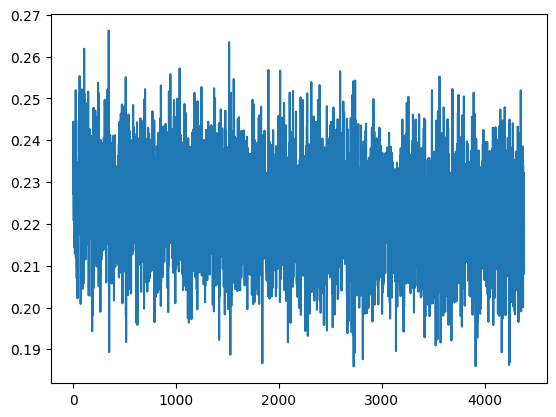

In [31]:
plt.plot(lossi)

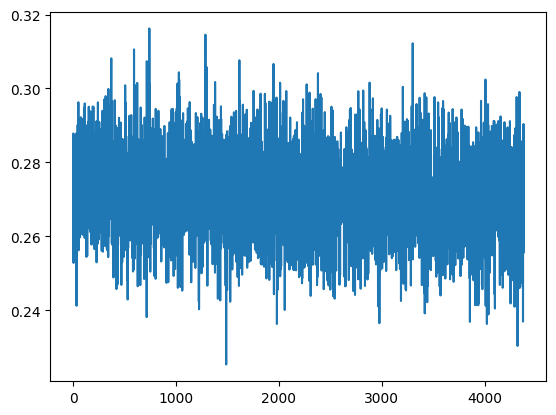

In [32]:
plt.plot(lossi_dev)

# Sample the model

In [33]:
g_gpu = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

i = 0

iys = []
context = [0] * BLOCK_SIZE
while True:
  x = torch.tensor([context]).to(device)
  logits = net(x)
  prob = F.softmax(logits, dim=1)
  iy = torch.multinomial(prob, num_samples=1, replacement=True, generator=g_gpu)

  if i > 1000:
    break

  iys.append(iy.item())
  context = context[1:] + [iy.item()]

  i += 1

print(decode(iys))

even mend,
Which pach him dorbany ere them the hows?

AURTHAS:
He waske. Lomanol-re, him stain sucking tixcordond it upporack.

LARTHUS:
To trought assure thou dea, counted the come;
Thommy prither's hart a'll to resage.

CLARIO:
ANULARD:
That lot is my fait: with do pomion, trosbine to those proath, for eres?
Sirst Selushm's good the Ruckert-ice, parthing,
Siven thou, and bears, Lurdind it the greendbro stomiting.

DENHFLIDUKENG:
Nuch uncless ardily hath me for.
UING from thou not arms as your sollow that nothow think high anried, throw abvilialt.

MIRENCE EO:
Mome, he wish I comping on they baw
Thild leto him down!
How fortholked whall, it is somenty could be prisped would chen to hed againg. Herwifor dreaking unge,
Teaven the afficestion
And thanger Come a bodden ans fear,
Rill, they hop gid to at ther
What eusween my hath oatenstand so him,
Beew pomes flom,--
Then to stocendom courth him for, to chame:
Out of the while'd may my this straught is telt by my?

CUTUCHENRY VIRCENV O, Yo